# Cell motility study

In this notebook we will go through how we can use PhysiCOOL to test the effect of the cell motility parameters on the cells' trajectories and migration patterns. We will start by creating a simple black box model to run the simulation through Python and then adding other components to extend its functionalities.

## Setting up the environment

We can use PhysiCOOL to compile our project with a Python command and create a black box that can be used to run the PhysiCell model (we must be in the same directory as the simulation files).

In [3]:
from physicool import optimization as opt

# Compiles the project and creates a black box object for it
opt.compile_project()    
black_box = opt.PhysiCellBlackBox()

g++ -march=native  -O3 -fomit-frame-pointer -mfpmath=both -fopenmp -m64 -std=c++11  -o project BioFVM_vector.o BioFVM_mesh.o BioFVM_microenvironment.o BioFVM_solvers.o BioFVM_matlab.o BioFVM_utilities.o BioFVM_basic_agent.o BioFVM_MultiCellDS.o BioFVM_agent_container.o   pugixml.o PhysiCell_phenotype.o PhysiCell_cell_container.o PhysiCell_standard_models.o PhysiCell_cell.o PhysiCell_custom.o PhysiCell_utilities.o PhysiCell_constants.o PhysiCell_basic_signaling.o PhysiCell_signal_behavior.o  PhysiCell_SVG.o PhysiCell_pathology.o PhysiCell_MultiCellDS.o PhysiCell_various_outputs.o PhysiCell_pugixml.o PhysiCell_settings.o PhysiCell_geometry.o custom.o main.cpp 


main.cpp: In function ‘int main(int, char**)’:
main.cpp:106:8: warning: ignoring return value of ‘int system(const char*)’, declared with attribute warn_unused_result [-Wunused-result]
  106 |  system( copy_command );
      |  ~~~~~~^~~~~~~~~~~~~~~~


make name
make[1]: Entering directory '/workspace/abm-worskshop'

Executable name is project

make[1]: Leaving directory '/workspace/abm-worskshop'


## Running the model

Running a model with the black box is quite easy: we just have to call the run() method. Furthermore, we can choose the number of replicates to be run and whether the output data should be saved (it will be stored in a new folder called temp).


In [28]:
opt.clean_tmp_files()
black_box.run(number_of_replicates=1, keep_files=True)

array([460.28544355, 458.50995906, 469.14312196, 469.09068212,
       427.33856112, 465.21725498, 455.51691682, 457.46184677,
       449.19387124, 435.83976838])

## Plotting the results

PhysiCOOL offers functions to extract and plot the cell trajectories both in 3D and 2D.

NameError: name 'ax' is not defined

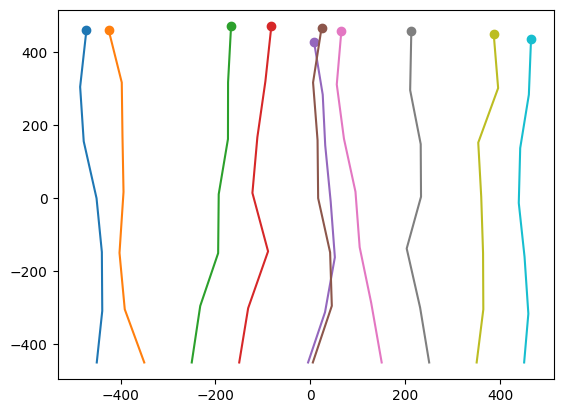

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from physicool.processing import get_cell_trajectories
from physicool.plotting import plot_trajectories_3d, plot_trajectories_2d


fig, ax = plt.subplots()
trajectories = get_cell_trajectories("temp")
plot_trajectories_2d(trajectories)

# Limits
ax.set_ylim(-500, 500)
ax.set_xlim(-500, 500)

# Grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)
ax.xaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)

# Ticks
ax.tick_params(axis="y", direction="in", right=True)
ax.tick_params(axis="x", direction="in", top=True)

plt.show()

## Adding a params updater to the black box

We can add a ParamsUpdater instance to our black box to update the XML file with new parameter values before the simulation is run.


In [27]:
from physicool.updaters import CellUpdater, update_motility_values
from physicool.processing import get_final_y_position

# Define the updater we want to use (change motility data)
new_values = {"migration_bias": 1}
updater = CellUpdater(updater_function=update_motility_values,
                     config_path="config/PhysiCell_settings.xml", cell_definition_name="default")

# Assign the updater and processor to the black box
black_box.updater = updater
black_box.processor = get_final_y_position

# Run the model with the new values
opt.clean_tmp_files()
black_box.run(params=new_values)

ValueError: The passed time point does not match any file.

<AxesSubplot: >

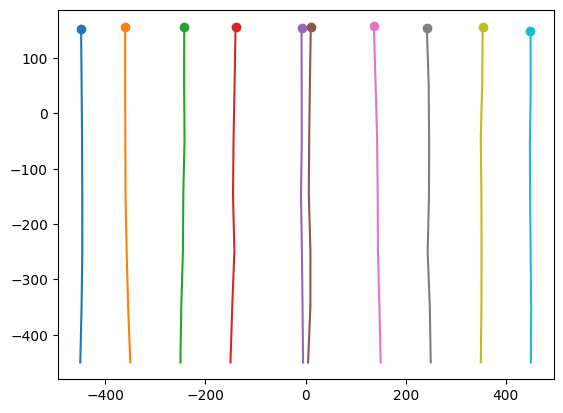

In [ ]:
# Plot the trajectories
trajectories = get_cell_trajectories("temp")
plot_trajectories_2d(trajectories)